As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

Open - the price the stock opened at.

High - the highest price during the day

Low - the lowest price during the day

Close - the closing price on the trading day

Volume - how many shares were traded

Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

# Stock Price Prediction

In [14]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [41]:
#load data

company = 'FB'
#when to start the data
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = web.DataReader(company, 'yahoo',start,end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2019-12-24,206.789993,205.000000,206.300003,205.119995,6046300,205.119995
2019-12-26,207.820007,205.309998,205.570007,207.789993,9350700,207.789993
2019-12-27,208.929993,206.589996,208.669998,208.100006,10284200,208.100006


In [44]:
# Prepare data
#scale down all the values we have so that they fit in between 0 and 1
scaler = MinMaxScaler(feature_range= (0,1)) # from the sklearn.preprocessing module
#We are predicting the price after markets have closed
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

#how many days do we want to base our prediction on. How many days do I want to look back to decide what the price is going to be for the next day
prediction_days = 10

x_train = []
y_train = []

#loading the data from the past 60 days into the training set
for x in range(prediction_days , len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
#convert into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
                   

In [45]:
#Build the model
model = Sequential()

#specify the layers
#the more units you have the longer you will have to train the model.
#also risk overfitting if too many layers
model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))#prediction of the next closing value

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs=25, batch_size=32)

'''Test the model accuracy on existing data'''

#load some test data
#has to be data that the model has not seen before
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start,test_end)
actual_price = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

model_inputs = model_inputs.reshape(-1,1)
#scale down using scaler we defined
model_inputs = scaler.transform(model_inputs)





Epoch 1/25
60/60 [==============================] - 8s 14ms/step - loss: 0.0453
Epoch 2/25
60/60 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 3/25
60/60 [==============================] - 1s 13ms/step - loss: 0.0034
Epoch 4/25
60/60 [==============================] - 1s 14ms/step - loss: 0.0033
Epoch 5/25
60/60 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 6/25
60/60 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 7/25
60/60 [==============================] - 1s 12ms/step - loss: 0.0028
Epoch 8/25
60/60 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 9/25
60/60 [==============================] - 1s 14ms/step - loss: 0.0032
Epoch 10/25
60/60 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 11/25
60/60 [==============================] - 1s 14ms/step - loss: 0.0026
Epoch 12/25
60/60 [==============================] - 1s 14ms/step - loss: 0.0022
Epoch 13/25
60/60 [==================

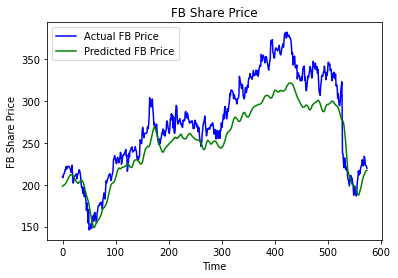

In [46]:
#make predictions

x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
                    
predicted_prices = model.predict(x_test)
#Inverting the scaler
predicted_prices = scaler.inverse_transform(predicted_prices)

#plot the test predictions
plt.plot(actual_price, color = 'blue', label = f"Actual {company} Price")
plt.plot(predicted_prices, color = 'green',label = f"Predicted {company} Price")

plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [47]:
#Predict next day

real_data = [model_inputs[len(model_inputs)  - prediction_days:len(model_inputs),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"predicted price: {prediction}")

predicted price: [[217.07634]]
